This notebook has been made with the help of the reference below :

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


### Data Fields
datetime - hourly date + timestamp 

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals (Dependent Variable)

In [3]:
from pandas.api.types import CategoricalDtype

import pylab
import calendar

import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [4]:
dailyData = pd.read_csv("../input/bike-sharing-demand/train.csv")

In [5]:
dailyData.shape

(10886, 12)

In [6]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [7]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# Feature Engineering

The columns "season","holiday","workingday" and "weather" should be of "categorical" type

 -> Let us transform the dataset in the following ways

1. Create new columns "date,"hour","weekDay","month" from "datetime" column.
2. Coerce the datatype of "season","holiday","workingday" and weather to category.
3. Drop the datetime column as we already extracted useful features from it.

# 1. Create new columns "date,"hour","weekDay","month" from "datetime" column.

In [8]:
dailyData.datetime

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [9]:
dailyData.datetime.apply(lambda x : x.split())

0        [2011-01-01, 00:00:00]
1        [2011-01-01, 01:00:00]
2        [2011-01-01, 02:00:00]
3        [2011-01-01, 03:00:00]
4        [2011-01-01, 04:00:00]
                  ...          
10881    [2012-12-19, 19:00:00]
10882    [2012-12-19, 20:00:00]
10883    [2012-12-19, 21:00:00]
10884    [2012-12-19, 22:00:00]
10885    [2012-12-19, 23:00:00]
Name: datetime, Length: 10886, dtype: object

### 날짜 

In [10]:
dailyData.datetime.apply(lambda x : x.split()[0])

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: datetime, Length: 10886, dtype: object

### 시간

In [11]:
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":"))

dailyData["hour"]

0        [00, 00, 00]
1        [01, 00, 00]
2        [02, 00, 00]
3        [03, 00, 00]
4        [04, 00, 00]
             ...     
10881    [19, 00, 00]
10882    [20, 00, 00]
10883    [21, 00, 00]
10884    [22, 00, 00]
10885    [23, 00, 00]
Name: hour, Length: 10886, dtype: object

### 요일

아래 dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()]) 에서 'dateString' 자리에는 반드시 object type이 들어가야 한다. 

그리고 strptime을 통해 원하는 포맷의 datetime으로 바꿀 수 있다. 여기서 weekday() 함수를 쓰면 요일을 정수로 변환하여 반환한다. 아래와 같이!

월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6

이에 대해 다시 calendar.day_name[day] 를 쓰면 아래와 같이 요일이 나온다.

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


만약 weekday()가 아니라 month()를 쓰면 1, 2, ... 12까지의 월별 숫자가 나오고

calendar.month_name[month]을 하면 Jan, Feb,...와 같이 월별 이름이 나온다.


[변환 연습]

In [12]:
cal = calendar.Calendar()
cal.iterweekdays()   # 0 1 2 3 4 5 6

for day in cal.iterweekdays():
    print(calendar.day_name[day])

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


In [13]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData['dummy']=dailyData.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

dailyData['dummy']

0        5
1        5
2        5
3        5
4        5
        ..
10881    2
10882    2
10883    2
10884    2
10885    2
Name: dummy, Length: 10886, dtype: int64

In [14]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

In [15]:
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [16]:
dailyData.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,dummy,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,00,2011-01-01,5,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,01,2011-01-01,5,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,02,2011-01-01,5,Saturday,January


In [17]:
dailyData.drop('dummy', axis=1, inplace=True)   # 연습에 사용한 dummy 열은 삭제

In [18]:
dailyData.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,00,2011-01-01,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,01,2011-01-01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,02,2011-01-01,Saturday,January


# 2. Coerce the datatype of "season","holiday","workingday" and "weather" to category.

(coerce : 강제)

### *Type category*

The category data type in pandas is a hybrid data type. It looks and behaves like a string in many instances but internally is represented by an array of integers. This allows the data to be sorted in a custom order and to more efficiently store the data.

In [19]:
categoryVariableList = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [20]:
dailyData.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,00,2011-01-01,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,01,2011-01-01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,02,2011-01-01,Saturday,January


### *Data type 그래프로 나타내기*

In [21]:
dailyData.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
hour          category
date            object
weekday       category
month         category
dtype: object

In [22]:
dailyData.dtypes.value_counts()

int64       4
float64     3
category    2
object      2
category    1
category    1
category    1
category    1
category    1
dtype: int64

In [23]:
dailyData.date.dtype   # 확인 결과 date 열은 dtype이 object이다. 그냥 이렇게 둬도 되는건가??

dtype('O')

In [24]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts())

dataTypeDf.head(3)

,0
int64,4
float64,3
category,2


In [25]:
dataTypeDf = dataTypeDf.reset_index()

dataTypeDf.head(3)

,index,0
0,int64,4
1,float64,3
2,category,2


In [26]:
dataTypeDf = dataTypeDf.rename(columns={"index":"variableType",0:"count"})

dataTypeDf.head(3)

,variableType,count
0,int64,4
1,float64,3
2,category,2


*카테고리 만들기 연습*

In [27]:
# s = pd.Series(["a", "b", "c", "a"], dtype="category")

# s.dtypes

아래 cat_type은 category 변경이 하도 안돼서 쓴 코드다. 위에서 from pandas.api.types import CategoricalDtype 임포트도 해줬다...

In [28]:
 cat_type = CategoricalDtype(categories=["b", "c", "d"],ordered=True)

In [29]:
categoryVariableList = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

# 3. Drop the datetime column as we already extracted useful features from it.

In [30]:
dailyData  = dailyData.drop(["datetime"],axis=1)  # 이제 datetime 열의 용도는 끝났으므로 버린다.

### *A graph about how many dtypes there are*

In [31]:
dailyData.dtypes.value_counts()

int64       4
float64     3
category    2
category    1
category    1
category    1
category    1
category    1
object      1
dtype: int64

In [32]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})

dataTypeDf.head(3)

,variableType,count
0,int64,4
1,float64,3
2,category,2


아래 코드는 실행이 안돼서 일단 패스했다. 

In [33]:
# fig,ax = plt.subplots()
# fig.set_size_inches(12,5)
# sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
# ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

------------

# Missing value analysis

We're gonna use msno('missingno' module). Its a quiet handy library to quickly visualize variables for missing values.

<AxesSubplot:>

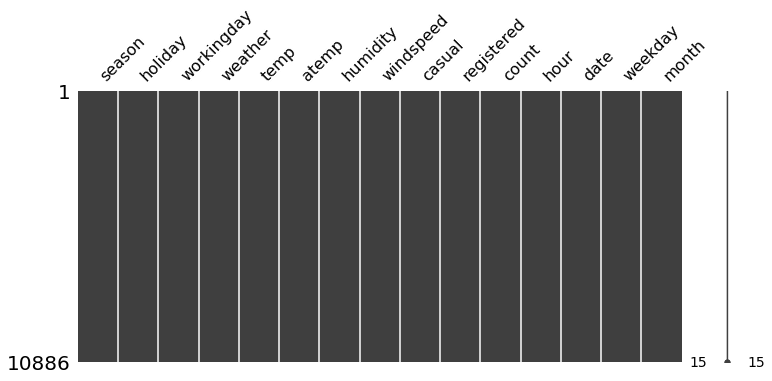

In [34]:
msno.matrix(dailyData,figsize=(12,5))

No missing value in the dataset

# Outliers Anlaysis

* Spring season has got relatively lower count. The dip in median value in boxplot gives evidence for it.
* The boxplot with "Hour Of The Day" is quiet interesting.The median values are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.
* Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

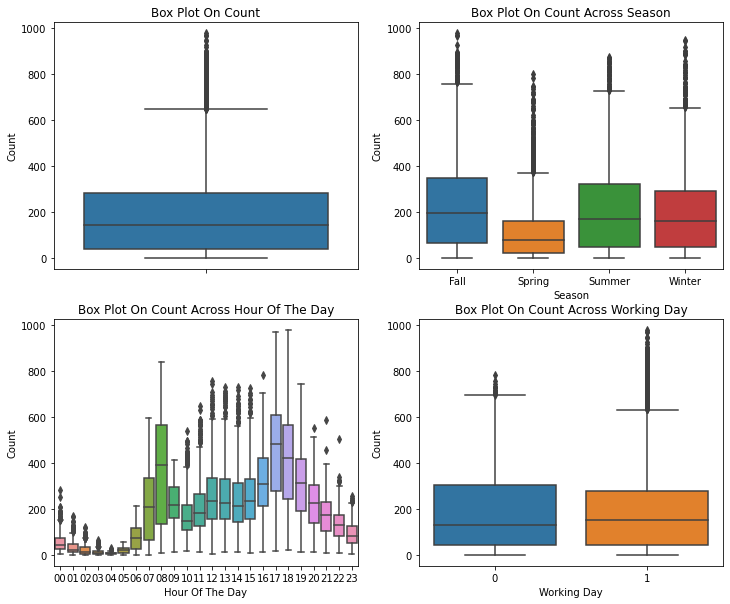

In [35]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

### *Removing outliers*

Removing outliers : 3 rolling standard deviations of a rolling mean 

np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())는 

np.abs(dailyData["count"])<=-dailyData["count"].mean() + (3*dailyData["count"].std())과 같다. 

즉, 평균에 3시그마(표준편차)를 더한 것보다는 값들이 작아야 한다. 거의 모든 값들(실제로는 99.7%)이 평균에서 양쪽으로 3표준편차 범위(μ±3σ)에 존재한다.

In [36]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

print(":",data)는 print(":"+data)와 같은 기능을 하는 듯 하다.

이상점을 제거하고 보니 그렇게 많이 제거되지는 않았다.

In [37]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


이상점 제거 후 박스플롯을 다시 확인해 보았다. 확인해 보니 그리 많이 사라지지는 않았다....

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

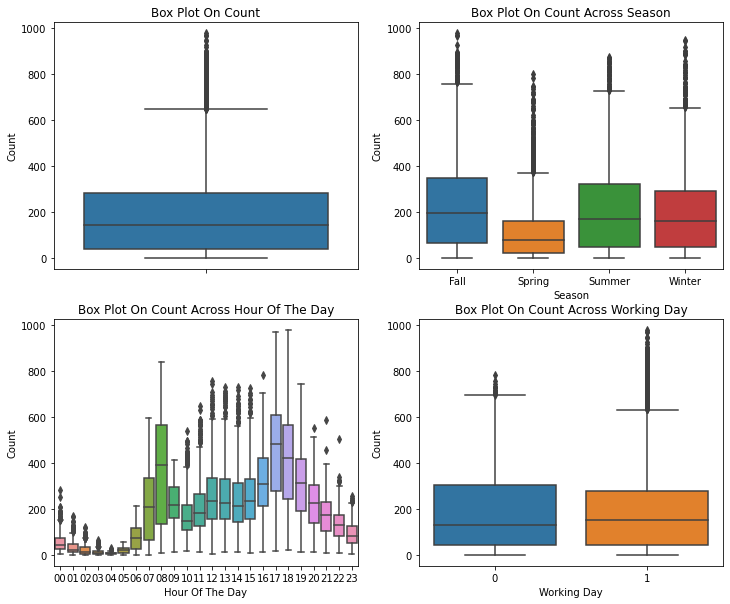

In [38]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

# Correlation Analysis

* temp and humidity features has got positive and negative correlation with count respectively. Although the correlation between them are not very prominent, still the count variable has got little dependency on "temp" and "humidity".

* windspeed is not gonna be really useful numerical feature and it is visible from its correlation value with "count"

* "atemp" variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit *multicollinearity* in the data.

  -> 'atemp'를 드랍한다.

* "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

  -> "Registered"의 경우 등록된 사람들이 렌트한 횟수, "Casual"의 경우 등록되지 않은 사람들이 렌탈을 한 횟수이다. 둘 다 '렌탈을 한 횟수'이기 때문에 이는 '렌탈 횟수(count)'가 있은 후에 만들어지는 데이터이다. 즉, 렌탈을 해야 얻을 수 있는 정보이기 때문에 데이터 누수(Data leakage)에 해당하므로 드랍한다.

### *다중 공선성(Multicollinearity)*

다중(Multiple), 즉 여러개의 독립변수(X 인자)가 서로 선형의 상관성이 높은 정도를 나타내는 개념입니다. 이게 왜 중요하냐하면 다중 공선성이 높으면 각 X 인자의 반응치 Y에 대한 설명력이 낮게 해석되어 큰 오류를 범할 수 있기 때문입니다

(예전에 이것을 이렇게 설명했던 적이 있습니다. 회귀 분석은 X 인자들의 독립성을 전제로 각 X 인자들의 Y에 대한 설명력을 분석하는 방법인 데, 각 X 인자의 상관성이 높으면, 예를 들어 X1 인자와 X2 인자가 상관성이 높으면 X2 인자가 Y에 대해 설명할 부분을 X1 인자가 많은 부분을 설명해 버리므로 X2 인자의 Y에 대한 설명력이 실제보다 작게 계산된다는 문제점이 있습니다.)

보통 상관 계수가 0.9 이상이면 다중 공선성이 높다고 판단한다.

[출처] 다중 공선성(Multicollinearity)의 확인과 처리|작성자 JMP 활용 가이드
(https://blog.naver.com/shinikju/221912144879)

### *데이터 누수*

데이터 누수는 훈련 데이터에 타겟에 대한 정보가 포함됐지만, 그 정보를 실제 예측에서는 사용할 수 없는 경우 발생한다. 이는 훈련 데이터 셋, 심지어 검증 데이터 셋에서도 높은 성능을 이끌어낼 수 있는 반면, 모델이 실제 배포됐을 때 제대로 동작하지 않을 것이다.

데이터 누수에는 2가지 주요 유형이 있다. 타겟 누수(target leakage)와 훈련-테스트 오염(train-test contamination)이 바로 그것이다.

타겟 누수(Target leakage)는 예측 시점에서 사용할 수 없는 데이터가 데이터 셋에 포함되어 있을 때 발생한다. 단순히 어떤 특성이 좋은 예측을 위해 필요한가만 고민하는 것뿐만 아니라, 해당 특성을 사용할 수 있게 되는 타이밍이나 시간 순서의 관점에서 타겟 누수에 대해 생각해 볼 필요가 있다.

예를 들어 누가 폐럼에 걸릴지 예측하고 싶다고 하자. 원본 데이터의 상위 몇 행은 아래와 같다.

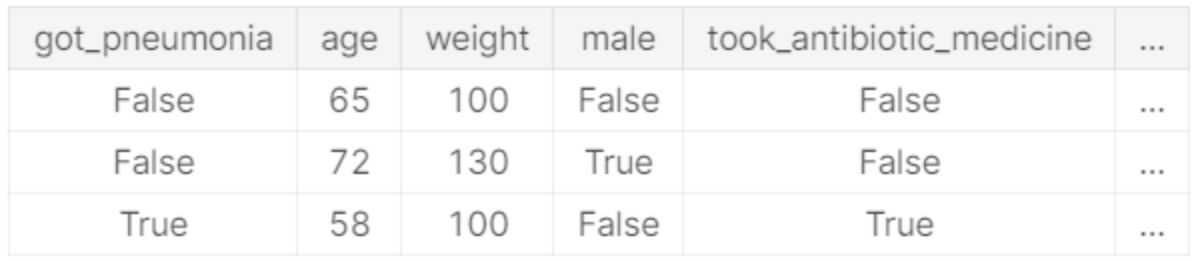


사람들은 폐렴에 걸린 후 회복을 위해 항생제를 복용한다. 원본 데이터에서 got_pneumonia(폐렴에 걸림)과 took_antibiotic_medicine(항생제를 복용함) 열 사이에 강한 관계가 있다는 것을 확인할 수 있다. 이것이 타겟 누수이다. 이 모델이 실제 환경에서 사용되게 된다면 매우 부정확할 것이다. 왜냐하면 폐렴에 걸린 환자인지 아닌지 예측하는 시점에서, 환자는 아직 항생제를 투여받지 못했을 것이기 때문이다.

이런 유형의 데이터 누수를 방지하려면, 타겟 값이 결정된 후 생성된 모든 변수들을 데이터 셋에서 제외해야 한다.

[출처] 7. Data Leakage|작성자 Zinc(https://blog.naver.com/hongjg3229/221811766581)

In [39]:
dailyData.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,weekday,month
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,00,2011-01-01,Saturday,January
1,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,01,2011-01-01,Saturday,January
2,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,02,2011-01-01,Saturday,January
3,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,03,2011-01-01,Saturday,January
4,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,04,2011-01-01,Saturday,January


* 위에서 새롭게 만들어준 category 열 7개("hour", "weekday", "month", "season", "weather", "holiday", "workingday") 7열을 제외하고, temp, atemp, humidity, winspeed, casual, registered(not categorical but numerical columns)과 count의 상관관계를 살펴 본다.

<AxesSubplot:>

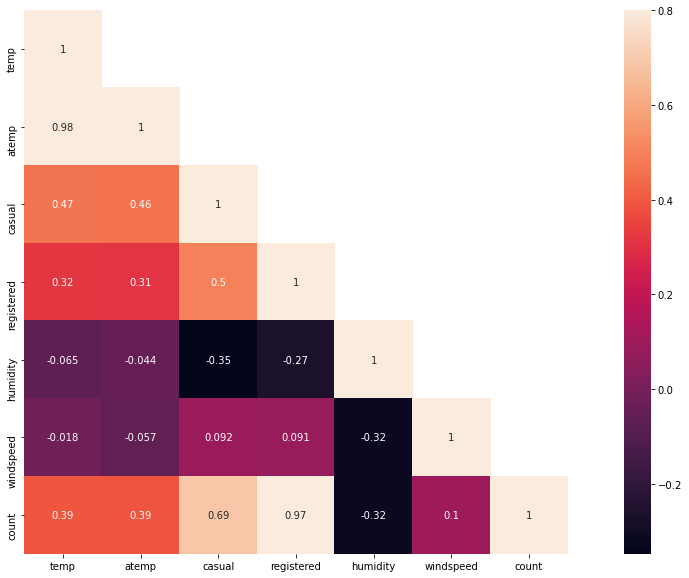

In [50]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
 # numpy.triu_indices_from(arr, k=0)는 upper triangle이 보이게 해줌/numpy.tril_indices_from(arr, k=0)는 lower triangle이 보임
 # arrndarray, shape(N, N) : The indices will be valid for square arrays.
 # k : int, optional, diagonal offset -> triu의 경우 a matrix with the elements below the k-th diagonal zeroed가 보이게 되므로 k는 대각선이 0가 되도록 만드는 것 같음
 # 만약 mask[np.tril_indices_from(mask)] = False 이부분이 True가 되면 아래 그래프에서 아무것도 나오지 않음 -> 즉 False로 해야 corrMatt 부분만 보이도록 하라는 뜻이 된다. 
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
 # vmax는 색으로 표현하는 값의 최댓값, vmin은 최솟값 -> 즉 상관관계의 범위를 예상하고 있으면 어느 정도로 해야 색 분포가 될 지를 알기 때문에 vmax, vmin을 정해 주는 것

그렇다면 이제 windspeed, atemp, casual, registeredf를 드랍하고 남은 세 독립변수(속성)과 count의 regresssion을 살펴 본다. 

<AxesSubplot:xlabel='humidity', ylabel='count'>

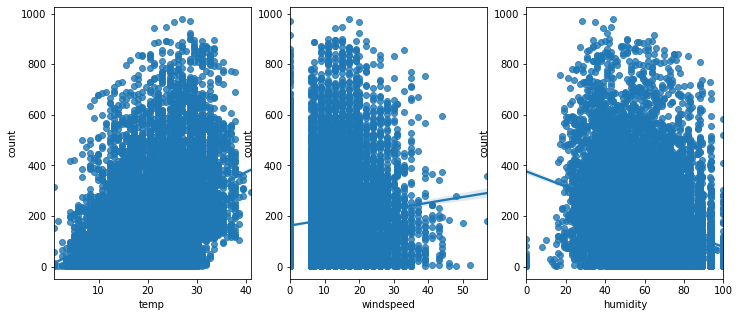

In [54]:
fig,ax = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=dailyData,ax=ax[0])
sns.regplot(x="windspeed", y="count", data=dailyData,ax=ax[1])
sns.regplot(x="humidity", y="count", data=dailyData,ax=ax[2])